# Figure 6: Train-time comparison (ReLU vs Softmax)

Plots average training time per epoch for ReLU vs Softmax across architectures and `m` values for MNIST and CIFAR10.


In [11]:
from pathlib import Path
import pandas as pd

arch_colors = {
    "all_performer": "#4C78A8",
    "performer_first": "#72B7B2",
    "standard_first": "#54A24B",
    "intertwined": "#F58518",
}


def find_results_dir(dataset: str, start=None) -> Path:
    start = Path.cwd() if start is None else Path(start)
    for path in [start, *start.parents]:
        candidate = path / "results" / dataset
        if candidate.exists():
            return candidate
    raise FileNotFoundError(f"Could not find results/{dataset} relative to the current working directory.")


def load_dataset(dataset: str, drop_m_512: bool = False) -> pd.DataFrame:
    results_dir = find_results_dir(dataset)
    summary_files = sorted(results_dir.glob("summary_*.csv"))
    if not summary_files:
        raise FileNotFoundError(f"No summary_*.csv files found under {results_dir}")
    rows = []
    for csv_path in summary_files:
        df = pd.read_csv(csv_path)
        if "best_test_acc" not in df.columns:
            continue
        for _, row in df.iterrows():
            if str(row.get("dataset", "")).lower() != dataset.lower():
                continue
            kernel = str(row.get("kernel_type", ""))
            if kernel not in {"relu", "softmax"}:
                continue
            arch = str(row.get("architecture", "unknown"))
            if arch not in arch_colors:
                continue
            m_feat = str(row.get("m_features", ""))
            if drop_m_512 and m_feat == "512":
                continue
            rows.append(
                {
                    "architecture": arch,
                    "kernel_type": kernel,
                    "m_features": m_feat,
                    "avg_train_time_per_epoch": float(row.get("avg_train_time_per_epoch", float("nan"))),
                    "infer_time_per_batch_mean_ms": float(row.get("infer_time_per_batch_mean_ms", float("nan"))),
                    "infer_time_per_batch_std_ms": float(row.get("infer_time_per_batch_std_ms", float("nan"))),
                    "summary_file": csv_path.name,
                }
            )
    df_out = pd.DataFrame(rows)
    if df_out.empty:
        raise ValueError(f"No rows with relu/softmax found in summary files for {dataset}.")
    return df_out

mnist_df = load_dataset("MNIST", drop_m_512=False)
cifar_df = load_dataset("CIFAR10", drop_m_512=True)
mnist_df.head(), cifar_df.head()


(    architecture kernel_type m_features  avg_train_time_per_epoch  \
 0  all_performer        relu        128                 26.479081   
 1  all_performer        relu         16                 13.945965   
 2  all_performer        relu        256                 39.444860   
 3  all_performer        relu         32                 15.906823   
 4  all_performer        relu         64                 19.378669   
 
    infer_time_per_batch_mean_ms  infer_time_per_batch_std_ms  \
 0                     19.304585                     3.133224   
 1                      8.364348                     1.887454   
 2                     30.536399                     4.386446   
 3                      9.753799                     2.015811   
 4                     13.023071                     1.463969   
 
                                        summary_file  
 0  summary_arch-all_performer_kernel-relu_m-128.csv  
 1   summary_arch-all_performer_kernel-relu_m-16.csv  
 2  summary_arch-all_

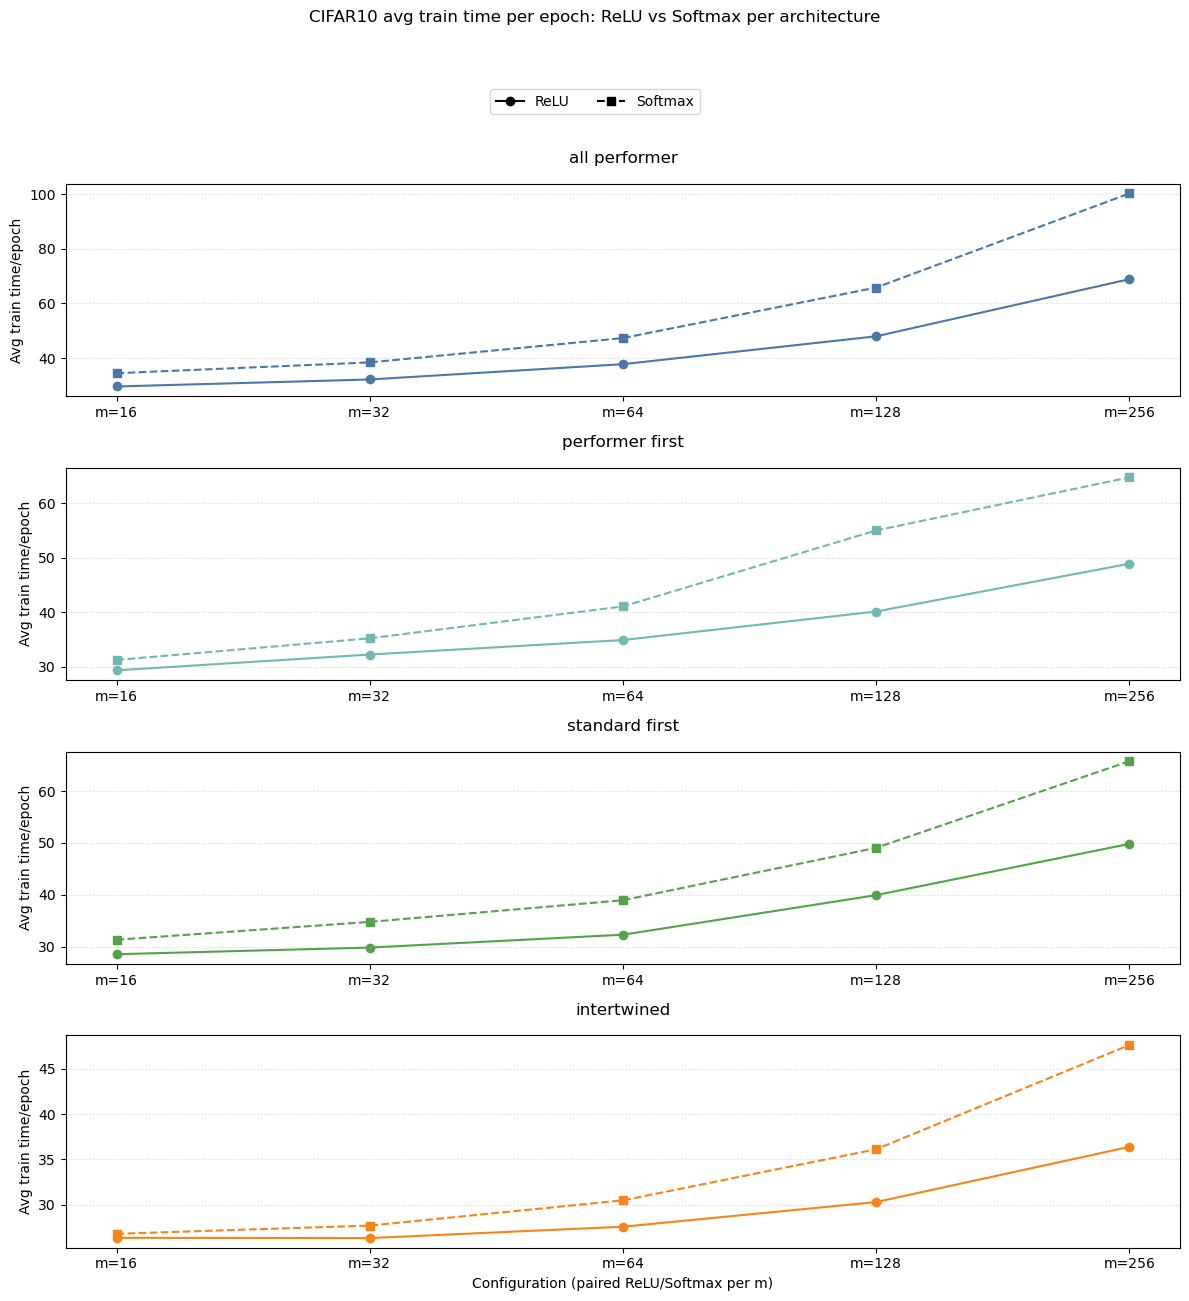

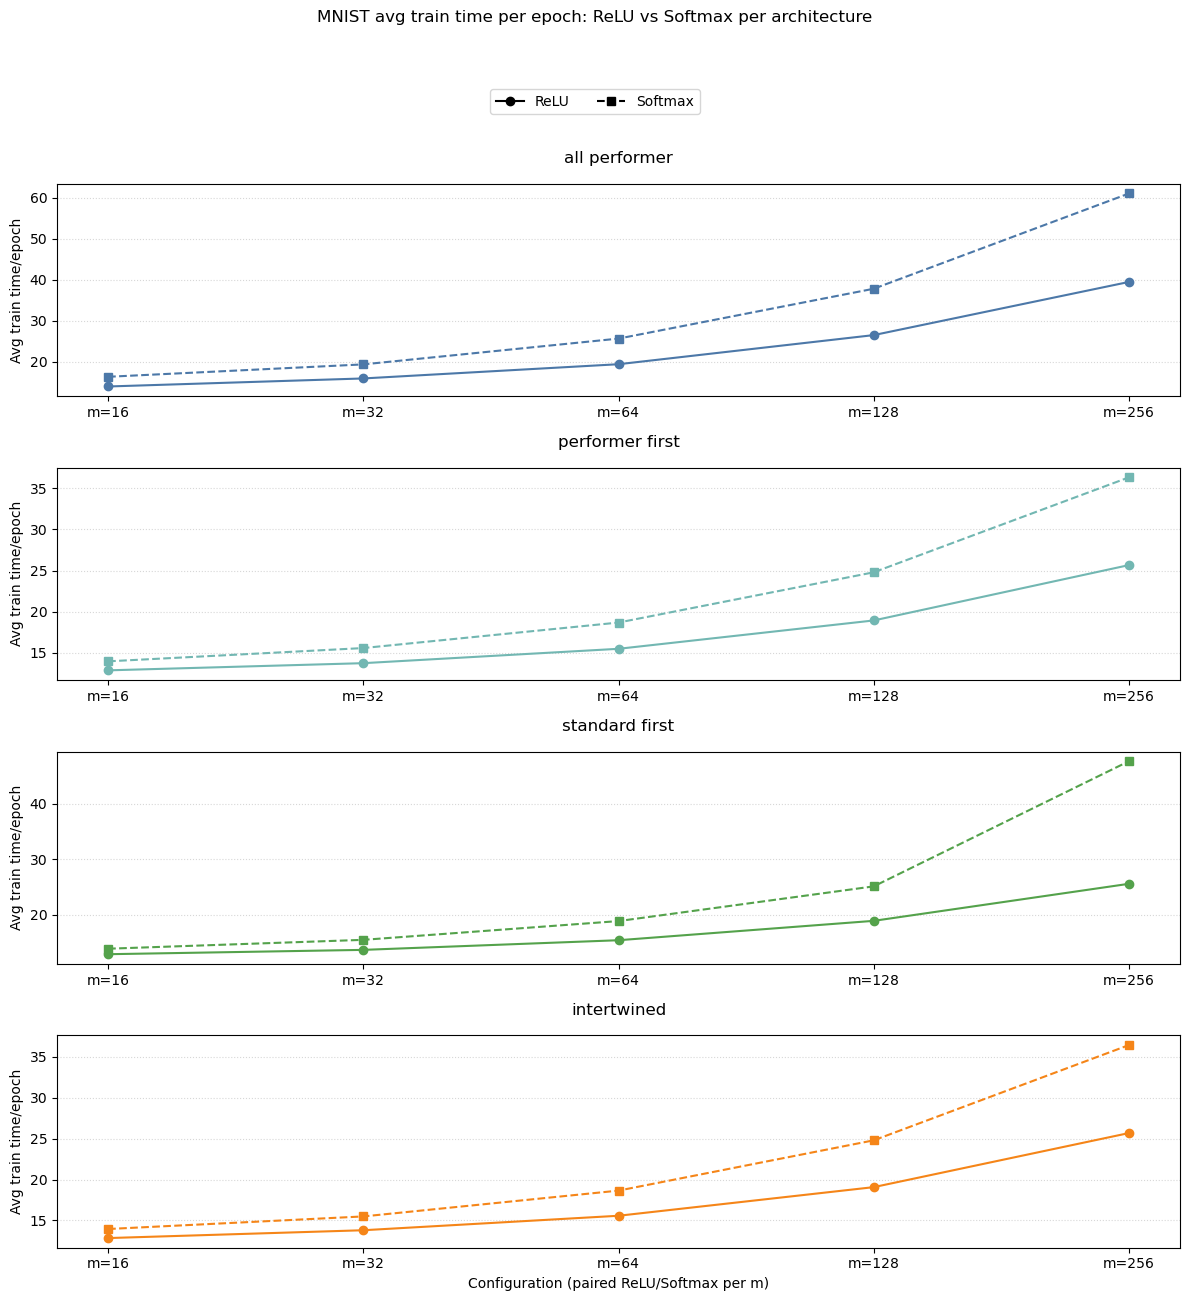

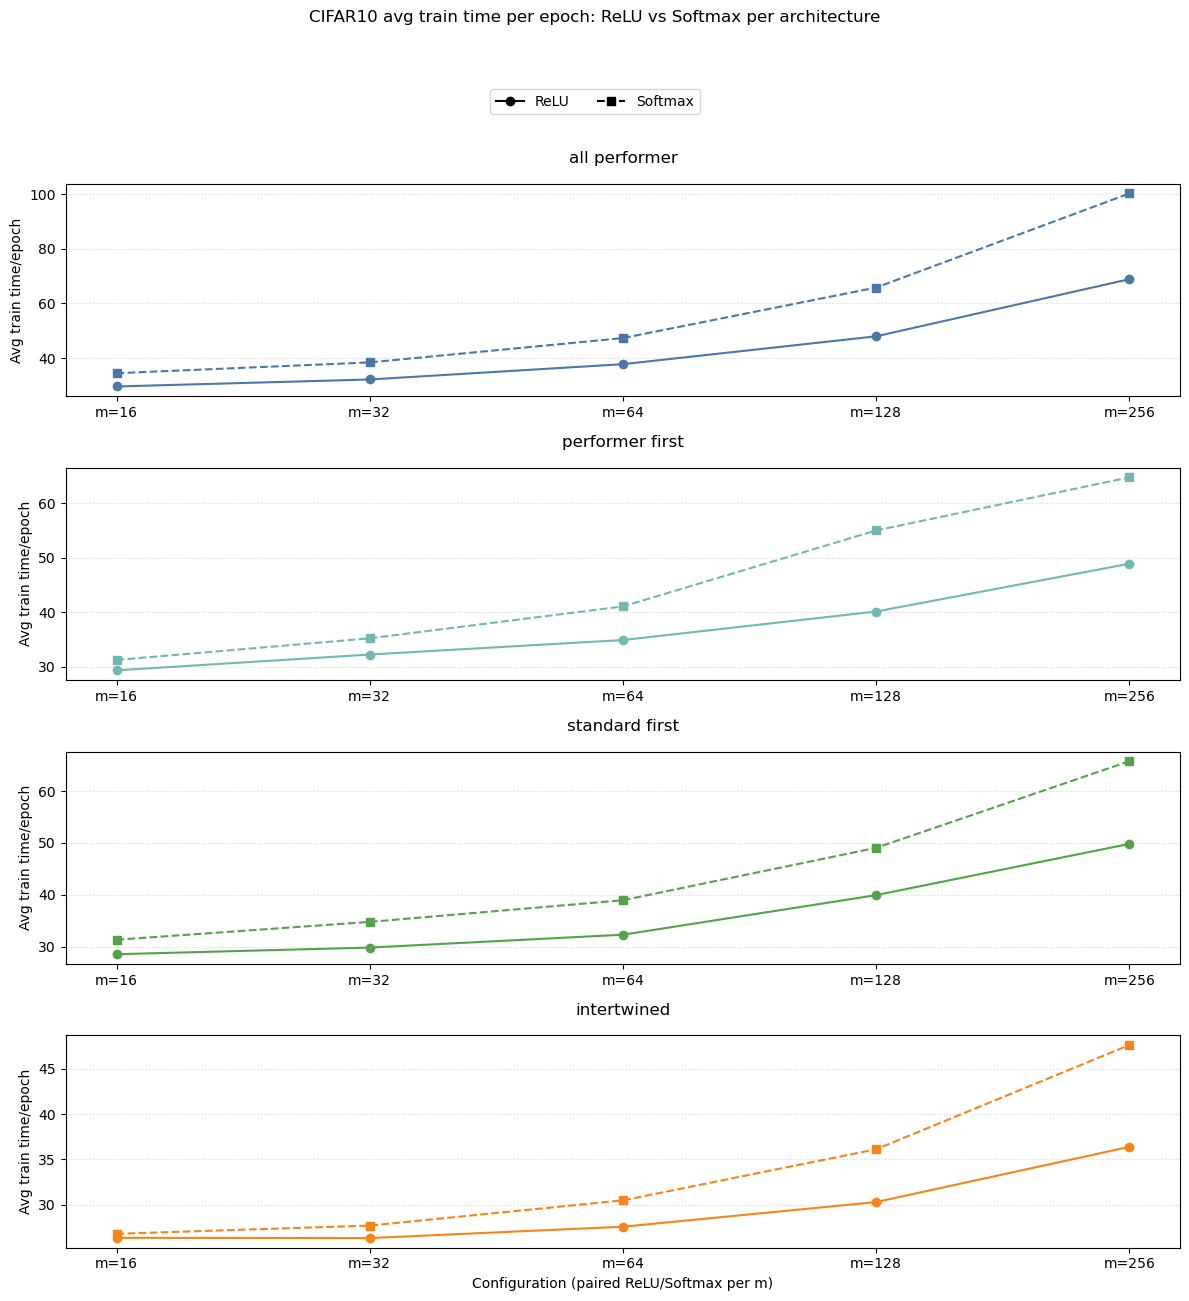

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

line_styles = {"relu": "-", "softmax": "--"}
markers = {"relu": "o", "softmax": "s"}


def m_sort_key(val: str):
    try:
        return float(val)
    except ValueError:
        return val


def plot_time(df: pd.DataFrame, dataset: str, ylim=None):
    architectures = [a for a in arch_colors if a in df["architecture"].unique()]
    if not architectures:
        raise ValueError(f"No architectures found in df matching arch_colors keys for {dataset}.")

    fig, axes = plt.subplots(len(architectures), 1, figsize=(12, max(3, 3 * len(architectures))), sharex=False)
    if len(architectures) == 1:
        axes = [axes]

    for ax, arch in zip(axes, architectures):
        df_arch = df[df["architecture"] == arch]
        if df_arch.empty:
            continue
        m_values = sorted(df_arch["m_features"].unique(), key=m_sort_key)
        x = np.arange(len(m_values))

        for kernel in ["relu", "softmax"]:
            vals = []
            for m in m_values:
                row = df_arch[(df_arch["m_features"] == m) & (df_arch["kernel_type"] == kernel)]
                vals.append(float(row["avg_train_time_per_epoch"].iloc[0]) if not row.empty else np.nan)
            ax.plot(
                x,
                vals,
                line_styles[kernel],
                color=arch_colors[arch],
                marker=markers[kernel],
                label=kernel.capitalize(),
                zorder=2,
            )

        ax.set_title(arch.replace("_", " "), pad=15)
        ax.set_ylabel("Avg train time/epoch")
        ax.set_xticks(x)
        ax.set_xticklabels([f"m={m}" for m in m_values])
        ax.grid(axis="y", linestyle=":", alpha=0.5, zorder=1)
        if ylim:
            ax.set_ylim(*ylim)

    axes[-1].set_xlabel("Configuration (paired ReLU/Softmax per m)")

    style_handles = [
        Line2D([0], [0], color="black", linestyle=line_styles["relu"], marker=markers["relu"], label="ReLU"),
        Line2D([0], [0], color="black", linestyle=line_styles["softmax"], marker=markers["softmax"], label="Softmax"),
    ]
    fig.legend(handles=style_handles, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))
    fig.suptitle(f"{dataset} avg train time per epoch: ReLU vs Softmax per architecture", y=1.08)
    plt.tight_layout()
    return fig

# Call only what you want to display
plot_time(mnist_df, "MNIST", ylim=None)
plot_time(cifar_df, "CIFAR10", ylim=None)


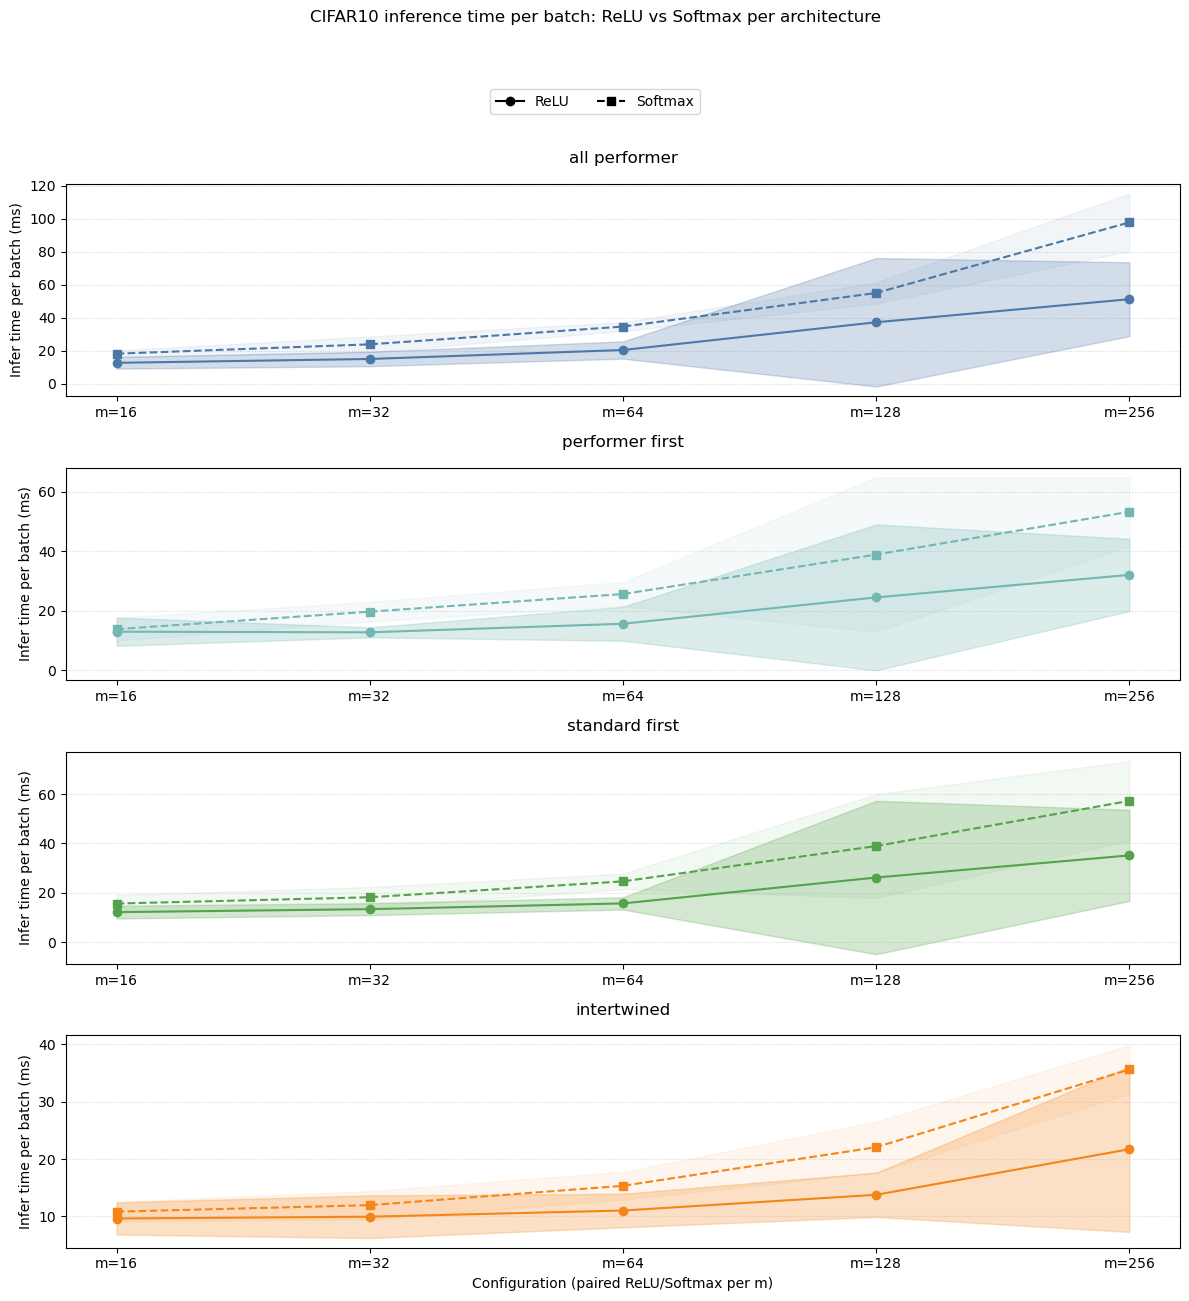

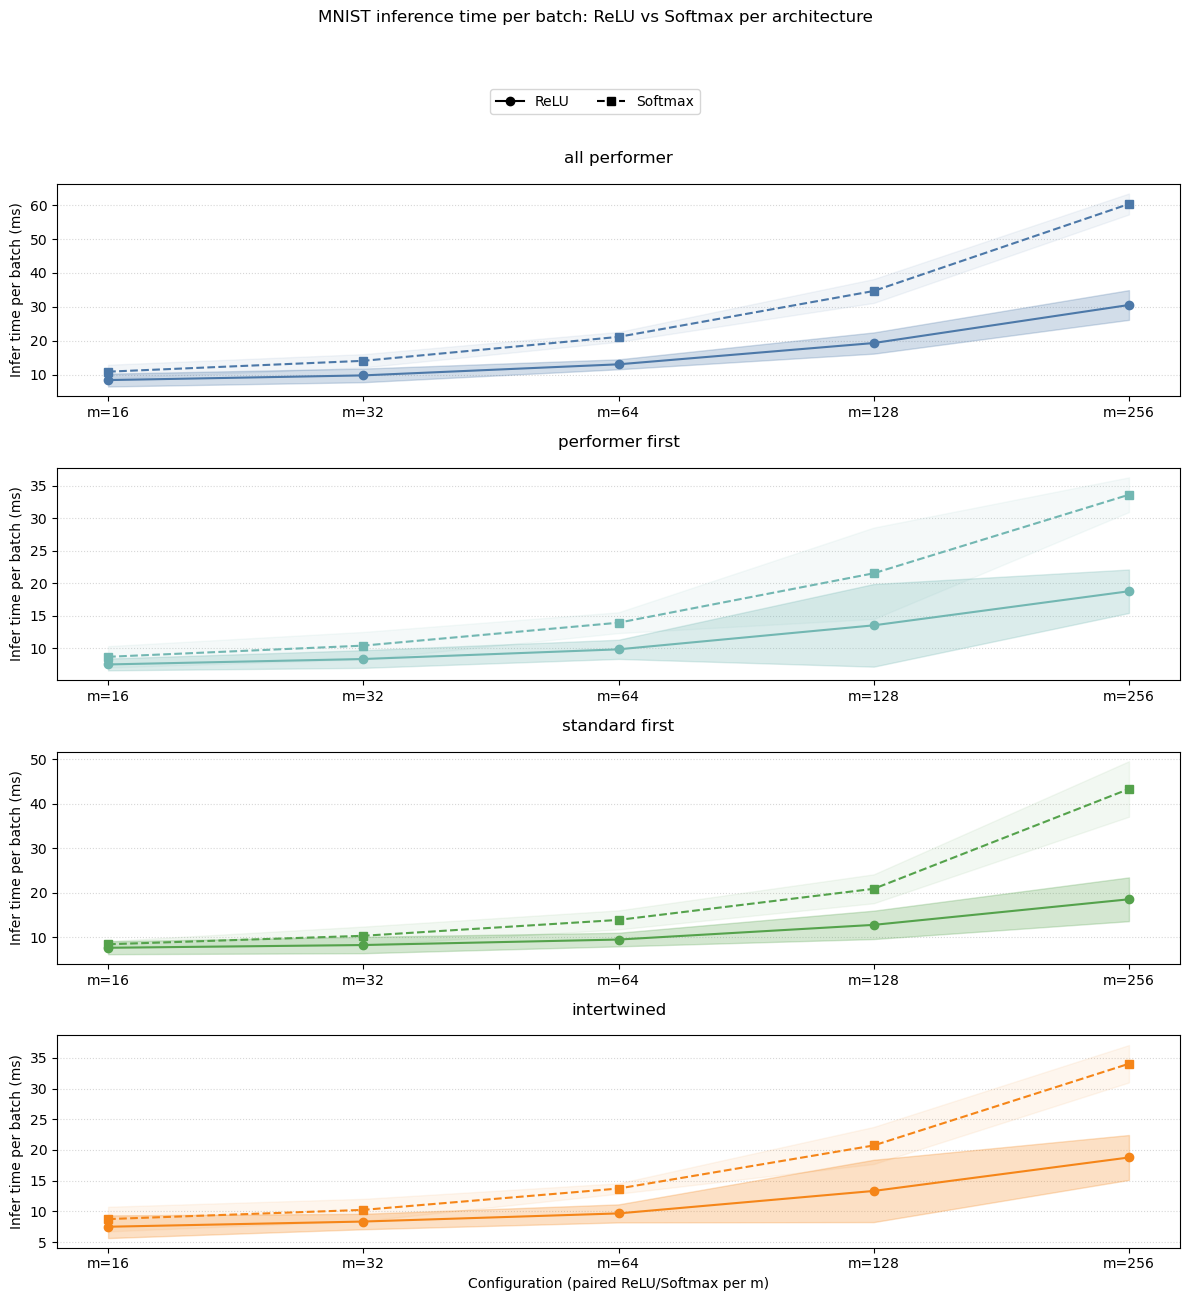

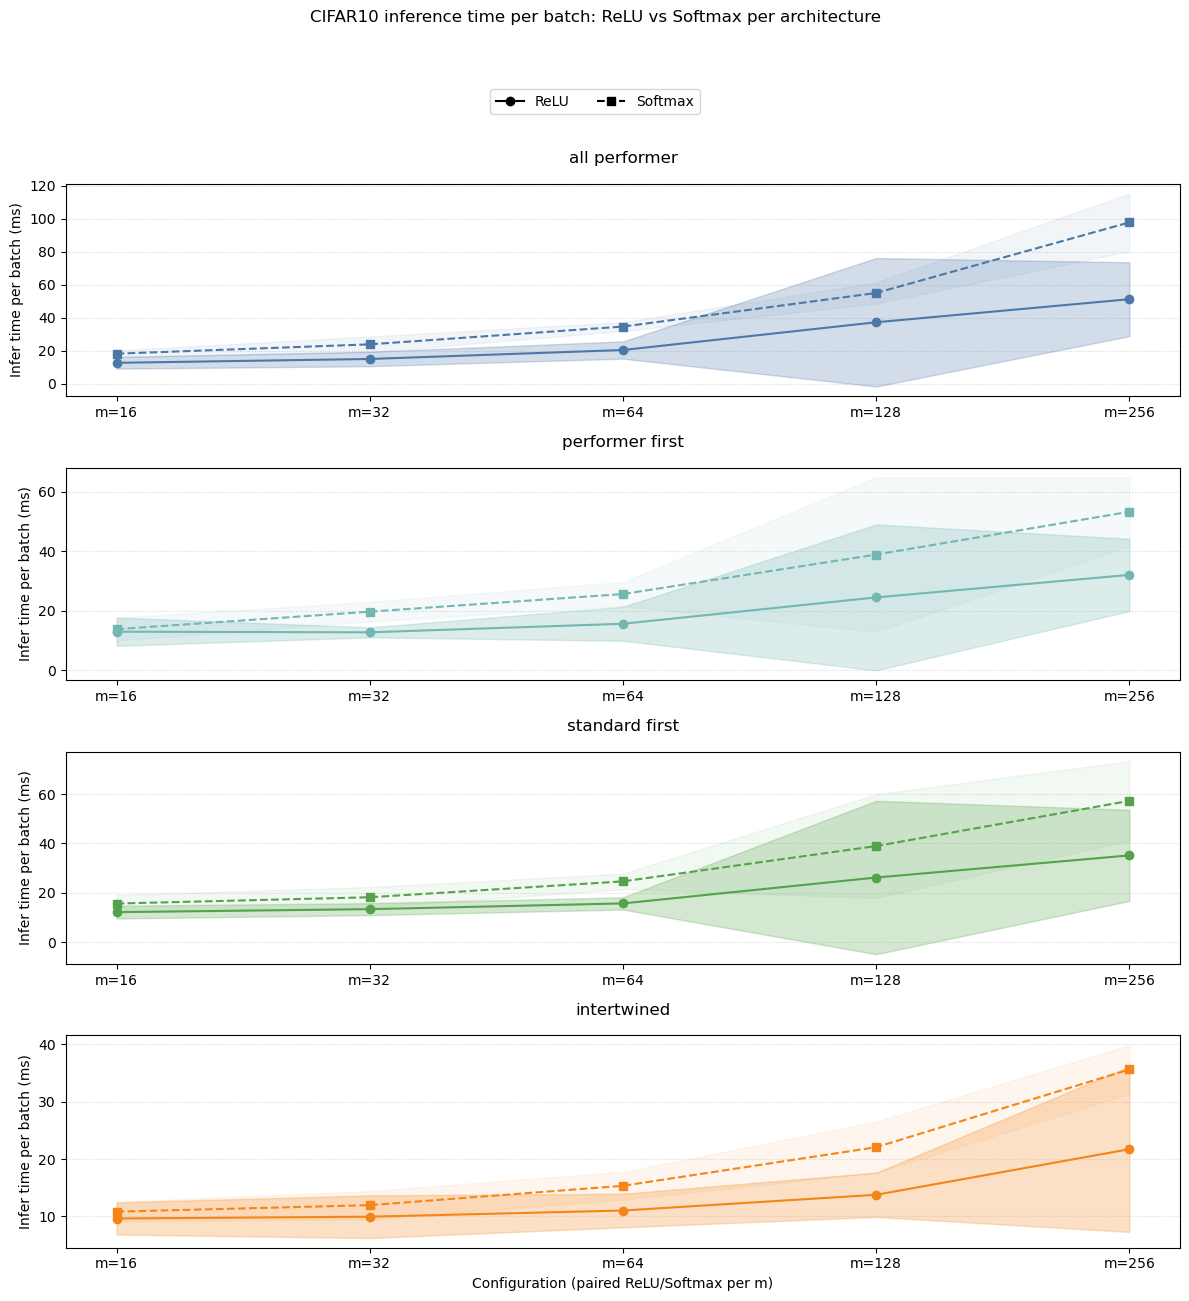

In [13]:
# Inference time plots with shaded bands (mean ± std)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

line_styles_inf = {"relu": "-", "softmax": "--"}
markers_inf = {"relu": "o", "softmax": "s"}


def plot_infer(df: pd.DataFrame, dataset: str, ylim=None):
    architectures = [a for a in arch_colors if a in df["architecture"].unique()]
    if not architectures:
        raise ValueError(f"No architectures found in df matching arch_colors keys for {dataset}.")

    fig, axes = plt.subplots(len(architectures), 1, figsize=(12, max(3, 3 * len(architectures))), sharex=False)
    if len(architectures) == 1:
        axes = [axes]

    for ax, arch in zip(axes, architectures):
        df_arch = df[df["architecture"] == arch]
        if df_arch.empty:
            continue
        m_values = sorted(df_arch["m_features"].unique(), key=m_sort_key)
        x = np.arange(len(m_values))

        for kernel in ["relu", "softmax"]:
            means = []
            errs = []
            for m in m_values:
                row = df_arch[(df_arch["m_features"] == m) & (df_arch["kernel_type"] == kernel)]
                if not row.empty:
                    means.append(float(row["infer_time_per_batch_mean_ms"].iloc[0]))
                    errs.append(float(row["infer_time_per_batch_std_ms"].iloc[0]))
                else:
                    means.append(np.nan)
                    errs.append(np.nan)
            means = np.array(means, dtype=float)
            errs = np.array(errs, dtype=float)
            ax.plot(
                x,
                means,
                line_styles_inf[kernel],
                color=arch_colors[arch],
                marker=markers_inf[kernel],
                label=kernel.capitalize(),
                zorder=3,
            )
            # Use stronger shading for ReLU, very light for Softmax to differentiate bands clearly.
            band_alpha = 0.25 if kernel == "relu" else 0.07
            ax.fill_between(
                x,
                means - errs,
                means + errs,
                color=arch_colors[arch],
                alpha=band_alpha,
                zorder=2,
            )

        ax.set_title(arch.replace("_", " "), pad=15)
        ax.set_ylabel("Infer time per batch (ms)")
        ax.set_xticks(x)
        ax.set_xticklabels([f"m={m}" for m in m_values])
        ax.grid(axis="y", linestyle=":", alpha=0.5, zorder=1)
        if ylim:
            ax.set_ylim(*ylim)

    axes[-1].set_xlabel("Configuration (paired ReLU/Softmax per m)")

    style_handles = [
        Line2D([0], [0], color="black", linestyle=line_styles_inf["relu"], marker=markers_inf["relu"], label="ReLU"),
        Line2D([0], [0], color="black", linestyle=line_styles_inf["softmax"], marker=markers_inf["softmax"], label="Softmax"),
    ]
    fig.legend(handles=style_handles, loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.02))
    fig.suptitle(f"{dataset} inference time per batch: ReLU vs Softmax per architecture", y=1.08)
    plt.tight_layout()
    return fig

plot_infer(mnist_df, "MNIST", ylim=None)
plot_infer(cifar_df, "CIFAR10", ylim=None)
